In [439]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net, MLP

In [440]:
n_epoch = 100000 #エポック
batchsize = 3000 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 200 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [441]:
xp = cuda.cupy if use_gpu is True else np

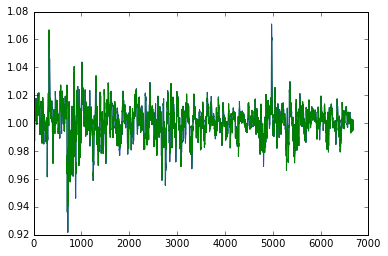

In [442]:
raw_data = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

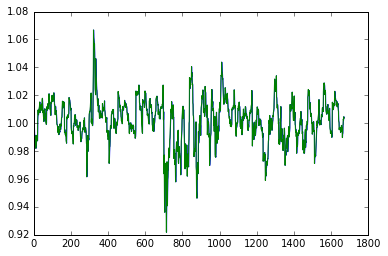

In [443]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [444]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(chainer.Variable(xp.asarray([[x_] for x_ in x])))
    error = F.mean_squared_error(out, chainer.Variable(xp.asarray([[y] for y in y], dtype=np.float32)))
    return chainer.cuda.to_cpu(out.data), error.data

In [445]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 500 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data * len(x) / length))
        #loss.append(loss_data * batchsize / length)
        
        loss.append(evaluate(model, train_data_x, train_data_y)[1])
        test_loss.append(evaluate(model, test_data_x, test_data_y)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 500, error 1.596282958984375
epoch 1000, error 0.33540189266204834
epoch 1500, error 0.0753307119011879
epoch 2000, error 0.013691228814423084
epoch 2500, error 0.02367028221487999
epoch 3000, error 0.01615198887884617
epoch 3500, error 0.012908194214105606
epoch 4000, error 0.0097144590690732
epoch 4500, error 0.011564494110643864
epoch 5000, error 0.010702619329094887
epoch 5500, error 0.011694670654833317
epoch 6000, error 0.01065971702337265
epoch 6500, error 0.011440861038863659
epoch 7000, error 0.01043299213051796
epoch 7500, error 0.009753214195370674
epoch 8000, error 0.010589201003313065
epoch 8500, error 0.010211984626948833
epoch 9000, error 0.010740991681814194
epoch 9500, error 0.009517078287899494
epoch 10000, error 0.0103038614615798
epoch 10500, error 0.00787350069731474
epoch 11000, error 0.009275230579078197
epoch 11500, error 0.01986531913280487
epoch 12000, error 0.032614968717098236
epoch 12500, error 0.08555213361978531
epoch 13000, error 0.0447411462664604

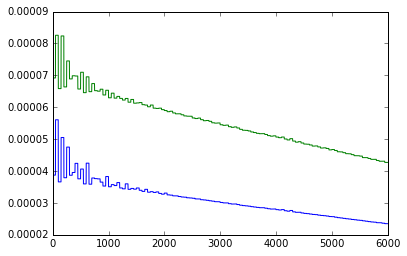

In [463]:
plt.plot(loss[-6000:])
plt.plot(test_loss[-6000:])

In [447]:
output, error = evaluate(model, train_data_x, train_data_y)

print(error)

2.338259764655959e-05


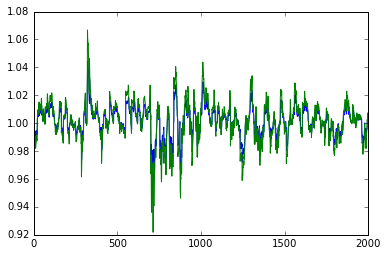

In [448]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

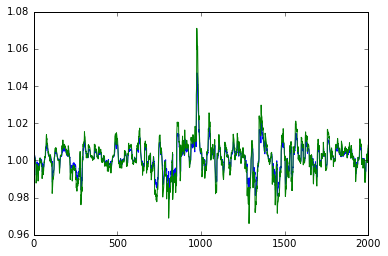

In [449]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [450]:
output, error = evaluate(model, test_data_x, test_data_y)
print('test error = {}'.format(error))

test error = 4.2521118302829564e-05


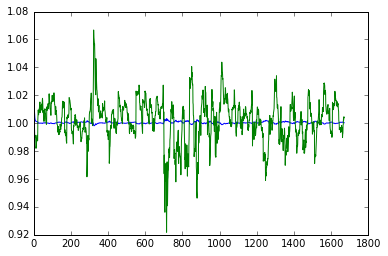

In [451]:
plt.plot(test)
plt.plot(test_data_x)